In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import BorderlineSMOTE

# Titanic DataSet

In [4]:
pdf = pd.read_csv('titanic.csv', header=0, sep=';')

In [5]:
pdf.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## EDA

In [6]:
pdf.shape

(1310, 14)

In [7]:
pdf['sex'] = pdf['sex'].map({'female': 1.0, 'male': 0.0})
pdf['embarked'] = pdf['embarked'].map({'C': 0.0, 'Q': 1.0, 'S': 2.0})
pdf['age'] = pdf['age'].apply(lambda val: str(val).replace(',', '.')).astype(float)
pdf['fare'] = pdf['fare'].apply(lambda val: str(val).replace(',', '.')).astype(float)

In [8]:
pdf.isna().sum()

pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1015
embarked        3
boat          824
body         1189
home.dest     565
dtype: int64

In [9]:
pdf = pdf.dropna(subset=['survived'])

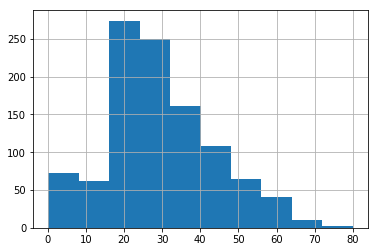

In [10]:
pdf['age'].hist()

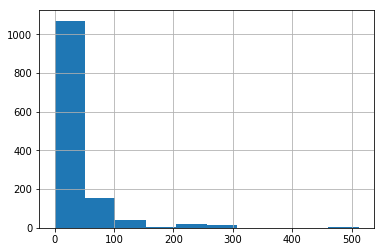

In [109]:
pdf['fare'].hist()

### Existing features analysis

In [9]:
pdf.groupby(['pclass'])['survived'].sum() / pdf.groupby(['pclass']).size()

pclass
1.0    0.619195
2.0    0.429603
3.0    0.255289
dtype: float64

In [10]:
pdf.groupby(['sex'])['survived'].sum() / pdf.groupby(['sex']).size()

sex
female    0.727468
male      0.190985
dtype: float64

In [11]:
pdf.groupby(['sex', 'pclass'])['survived'].sum() / pdf.groupby(['sex', 'pclass']).size()

sex     pclass
female  1.0       0.965278
        2.0       0.886792
        3.0       0.490741
male    1.0       0.340782
        2.0       0.146199
        3.0       0.152130
dtype: float64

In [12]:
pdf.groupby(['embarked'])['survived'].sum() / pdf.groupby(['embarked']).size()

embarked
C    0.555556
Q    0.357724
S    0.332604
dtype: float64

In [13]:
pdf.groupby(['parch'])['survived'].sum() / pdf.groupby(['parch']).size()

parch
0.0    0.335329
1.0    0.588235
2.0    0.504425
3.0    0.625000
4.0    0.166667
5.0    0.166667
6.0    0.000000
9.0    0.000000
dtype: float64

In [11]:
pdf['boated'] = (~pdf['boat'].isna()).astype(float)
pdf.groupby(['boated'])['survived'].sum() / pdf.groupby(['boated']).size()

boated
0.0    0.027947
1.0    0.981481
dtype: float64

In [16]:
pdf.groupby(['sex', 'pclass', 'boated'])['survived'].sum() / pdf.groupby(['sex', 'pclass', 'boated']).size()

sex     pclass  boated
female  1.0     0.0       0.166667
                1.0       1.000000
        2.0     0.0       0.400000
                1.0       1.000000
        3.0     0.0       0.099174
                1.0       0.989474
male    1.0     0.0       0.000000
                1.0       0.968254
        2.0     0.0       0.000000
                1.0       0.961538
        3.0     0.0       0.004819
                1.0       0.935897
dtype: float64

In [17]:
pdf.groupby(['sibsp'])['survived'].sum() / pdf.groupby(['sibsp']).size()

sibsp
0.0    0.346801
1.0    0.510972
2.0    0.452381
3.0    0.300000
4.0    0.136364
5.0    0.000000
8.0    0.000000
dtype: float64

## Modelling with TensorFlow

In [12]:
features = ['boated', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'fare']
pdf_clear = pdf[features + ['survived']]
X_train, X_test, y_train, y_test = train_test_split(pdf_clear[features], pdf_clear['survived'], test_size=0.5)

In [13]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)
y_train = pd.Series(y_train.values)
y_test = pd.Series(y_test.values)

In [4]:
class TFLogReg:
    def __init__(self, n_iter=100, learning_rate=0.05):
        self.n_iter = n_iter
        self.lr = learning_rate
        self.W = None
        self.b = None
    
    def _predict(self, X):
        return tf.nn.sigmoid(tf.matmul(X.values, self.W) + self.b)
    
    def predict(self, X):
        return self._predict(X).numpy()
    
    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            logit = self._predict(X)
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logit, labels=np.array([y]).T))
            W_grad, b_grad = tape.gradient(loss, [self.W, self.b])
        return W_grad, b_grad
        
    
    def fit(self, X, y):
        self.W = tf.Variable(tf.zeros([X_train.shape[1], 1], dtype=X.values.dtype))
        self.b = tf.Variable(tf.zeros([1], dtype=X.values.dtype))
        
        for i in range(self.n_iter):
            W_grad, b_grad = self.train_step(X, y)

            self.W.assign_sub(self.lr * W_grad)
            self.b.assign_sub(self.lr * b_grad)

We will try two different approaches of NaN-dealing:

### Filling NaNs with 0

In [84]:
model = TFLogReg(learning_rate=0.1, n_iter=100)
model.fit(X_train.fillna(0.0), y_train)
y_pred = model.predict(X_test.fillna(0.0))
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       425
         1.0       0.97      0.91      0.94       230

   micro avg       0.96      0.96      0.96       655
   macro avg       0.96      0.95      0.95       655
weighted avg       0.96      0.96      0.96       655

ROC-AUC score: 0.9878925831202047


### Filling NaNs with mean value

In [72]:
def fillna_mean(df):
    return df.fillna({col: df[col].mean() for col in df.columns})

In [73]:
model = TFLogReg(learning_rate=0.1, n_iter=100)
model.fit(fillna_mean(X_train), y_train)
y_pred = model.predict(fillna_mean(X_test))
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       425
         1.0       0.97      0.91      0.94       230

   micro avg       0.96      0.96      0.96       655
   macro avg       0.96      0.95      0.95       655
weighted avg       0.96      0.96      0.96       655

ROC-AUC score: 0.9878721227621483


## Modelling with Keras

In [78]:
def predict_logistic_regression_keras(X_train, y_train, X_test, n_iter=100, learning_rate=0.05, batch_size=50):
    model = Sequential()
    model.add(Dense(units=1, input_dim=X_train.shape[1], activation='sigmoid'))
    model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_iter)
    return model.predict(X_test)

### Filling NaNs with 0

In [79]:
y_pred = predict_logistic_regression_keras(X_train.fillna(0.0), y_train, X_test.fillna(0.0), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

Epoch 1/10
654/654 [==============================] - 0s 458us/sample - loss: 0.6874 - accuracy: 0.6468
Epoch 2/10
654/654 [==============================] - 0s 78us/sample - loss: 0.2900 - accuracy: 0.9602
Epoch 3/10
654/654 [==============================] - 0s 80us/sample - loss: 0.1953 - accuracy: 0.9771
Epoch 4/10
654/654 [==============================] - 0s 96us/sample - loss: 0.1569 - accuracy: 0.9801
Epoch 5/10
654/654 [==============================] - 0s 104us/sample - loss: 0.1359 - accuracy: 0.9801
Epoch 6/10
654/654 [==============================] - 0s 114us/sample - loss: 0.1228 - accuracy: 0.9801
Epoch 7/10
654/654 [==============================] - 0s 113us/sample - loss: 0.1139 - accuracy: 0.9801
Epoch 8/10
654/654 [==============================] - 0s 101us/sample - loss: 0.1073 - accuracy: 0.9801
Epoch 9/10
654/654 [==============================] - 0s 94us/sample - loss: 0.1025 - accuracy: 0.9801
Epoch 10/10
654/654 [==============================] - 0s 101us/samp

### Filling NaNs with mean value

In [80]:
y_pred = predict_logistic_regression_keras(fillna_mean(X_train), y_train, fillna_mean(X_test), n_iter=10, learning_rate=0.1, batch_size=50)
score = roc_auc_score(y_test, y_pred)
print(classification_report(y_test, y_pred > 0.5))
print('ROC-AUC score: {}'.format(score))

Epoch 1/10
654/654 [==============================] - 0s 491us/sample - loss: 0.4848 - accuracy: 0.7997
Epoch 2/10
654/654 [==============================] - 0s 80us/sample - loss: 0.2528 - accuracy: 0.9602
Epoch 3/10
654/654 [==============================] - 0s 77us/sample - loss: 0.1810 - accuracy: 0.9771
Epoch 4/10
654/654 [==============================] - 0s 63us/sample - loss: 0.1487 - accuracy: 0.9786
Epoch 5/10
654/654 [==============================] - 0s 74us/sample - loss: 0.1306 - accuracy: 0.9801
Epoch 6/10
654/654 [==============================] - 0s 106us/sample - loss: 0.1190 - accuracy: 0.9801
Epoch 7/10
654/654 [==============================] - 0s 108us/sample - loss: 0.1110 - accuracy: 0.9801
Epoch 8/10
654/654 [==============================] - 0s 116us/sample - loss: 0.1050 - accuracy: 0.9801
Epoch 9/10
654/654 [==============================] - 0s 93us/sample - loss: 0.1008 - accuracy: 0.9801
Epoch 10/10
654/654 [==============================] - 0s 103us/sampl

Keras model is a bit better, but still the results are almost the same

# Thyroid Disease DataSet

We have already done a full EDA of this dataset in HW3, so we will just be using preprocessed train and test sets from that notebook.

In [93]:
train = pd.read_csv('thyroid_train.csv')
test = pd.read_csv('thyroid_test.csv')

In [94]:
train.head()

,TSH,TT4,on_thyroxine,T4U,Class
0,-0.178313,-0.984492,0,1.176381,0
1,-0.165593,-0.070426,0,-0.662252,0
2,-0.093509,-0.896034,0,0.257065,0
3,-0.106229,0.047518,0,-0.554097,0
4,-0.166441,1.226959,0,0.202987,0


In [95]:
train.Class.value_counts()

0    2444
1     136
2      60
Name: Class, dtype: int64

In [96]:
test.Class.value_counts()

0    1037
1      58
2      37
Name: Class, dtype: int64

In [97]:
train.isna().sum()

TSH             0
TT4             0
on_thyroxine    0
T4U             0
Class           0
dtype: int64

In [98]:
test.isna().sum()

TSH             0
TT4             0
on_thyroxine    0
T4U             0
Class           0
dtype: int64

In [99]:
cols = ['TSH', 'TT4', 'on_thyroxine', 'T4U']
X_train = train[cols]
X_test = test[cols]
y_train = train['Class']
y_test = test['Class']

## Modelling with Tensorflow

In [131]:
class TFLogRegMulticlass(TFLogReg):
    def _predict(self, X):
        return tf.nn.softmax(tf.matmul(X, self.W) + self.b)
    
    def predict(self, X):
        return tf.argmax(self._predict(X), 1).numpy()
    
    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            logit = self._predict(X)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=y))
            W_grad, b_grad = tape.gradient(loss, [self.W, self.b])
        return W_grad, b_grad
        
    
    def fit(self, X, y):
        X, y = BorderlineSMOTE().fit_resample(X, y)
        y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).todense()
        
        self.W = tf.Variable(tf.zeros([X_train.shape[1], 3], dtype=X.dtype))
        self.b = tf.Variable(tf.zeros([3], dtype=X.dtype))
        
        for i in range(self.n_iter):
            W_grad, b_grad = self.train_step(X, y)            
            self.W.assign_sub(self.lr * W_grad)
            self.b.assign_sub(self.lr * b_grad)

In [138]:
model = TFLogRegMulticlass(learning_rate=20, n_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test.values)
print(classification_report(y_test, y_pred))
print(recall_score(y_test, y_pred, average='macro', labels=[1, 2]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1037
           1       0.77      1.00      0.87        58
           2       0.84      0.97      0.90        37

   micro avg       0.98      0.98      0.98      1132
   macro avg       0.87      0.98      0.92      1132
weighted avg       0.98      0.98      0.98      1132

0.9864864864864865


## Modelling with Keras

In [141]:
def predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=100, learning_rate=0.05):
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).todense()
    model = Sequential()
    model.add(Dense(units=3, input_dim=X_train.shape[1], activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.SGD(lr=learning_rate), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_iter)
    return np.argmax(model.predict(X_test), axis=1)

In [142]:
y_pred = predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=50, learning_rate=2)
print(classification_report(y_test, y_pred))
print(recall_score(y_test, y_pred, average='macro', labels=[1, 2]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Epoch 1/50
7332/7332 [==============================] - 1s 126us/sample - loss: 0.3252 - accuracy: 0.9343
Epoch 2/50
7332/7332 [==============================] - 1s 84us/sample - loss: 0.2000 - accuracy: 0.9739
Epoch 3/50
7332/7332 [==============================] - 1s 87us/sample - loss: 0.1807 - accuracy: 0.9783
Epoch 4/50
7332/7332 [==============================] - 1s 81us/sample - loss: 0.1719 - accuracy: 0.9802
Epoch 5/50
7332/7332 [==============================] - 1s 81us/sample - loss: 0.1667 - accuracy: 0.9806
Epoch 6/50
7332/7332 [==============================] - 1s 84us/sample - loss: 0.1637 - accuracy: 0.9805
Epoch 7/50
7332/7332 [==============================] - 1s 88us/sample - loss: 0.1618 - accuracy: 0.9812
Epoch 8/50
7332/7332 [==============================] - 1s 95us/sample - loss: 0.1603 - accuracy: 0.9820
Epoch 9/50
7332/7332 [==============================] - 1s 93us/sample - loss: 0.1598 - accuracy: 0.9823
Epoch 10/50
7332/7332 [==============================]

## Multi-layer modelling with Keras

In [204]:
def predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=100, learning_rate=0.05, inner_units=64):
    X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
    y_train = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).todense()
    model = Sequential()
    model.add(Dense(units=inner_units, input_dim=X_train.shape[1], activation='tanh'))
    model.add(Dense(units=3, input_dim=inner_units, activation='softmax'))
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.SGD(lr=learning_rate),
        metrics=['accuracy']
    )
    model.fit(X_train, y_train, epochs=n_iter)
    return np.argmax(model.predict(X_test), axis=1)

In [207]:
y_pred = predict_logistic_regression_keras_multiclass(X_train, y_train, X_test, n_iter=10, learning_rate=0.05, inner_units=128)
print(classification_report(y_test, y_pred))
print(recall_score(y_test, y_pred, average='macro', labels=[1, 2]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


Epoch 1/10
7332/7332 [==============================] - 1s 114us/sample - loss: 0.5946 - accuracy: 0.8022
Epoch 2/10
7332/7332 [==============================] - 1s 94us/sample - loss: 0.3434 - accuracy: 0.9554
Epoch 3/10
7332/7332 [==============================] - 1s 93us/sample - loss: 0.2474 - accuracy: 0.9712
Epoch 4/10
7332/7332 [==============================] - 1s 99us/sample - loss: 0.1981 - accuracy: 0.9772
Epoch 5/10
7332/7332 [==============================] - 1s 93us/sample - loss: 0.1712 - accuracy: 0.9774
Epoch 6/10
7332/7332 [==============================] - 1s 93us/sample - loss: 0.1556 - accuracy: 0.9794
Epoch 7/10
7332/7332 [==============================] - 1s 88us/sample - loss: 0.1453 - accuracy: 0.9800
Epoch 8/10
7332/7332 [==============================] - 1s 89us/sample - loss: 0.1381 - accuracy: 0.9821
Epoch 9/10
7332/7332 [==============================] - 1s 89us/sample - loss: 0.1326 - accuracy: 0.9819
Epoch 10/10
7332/7332 [==============================]

# Boston houses dataset

In [5]:
from sklearn.datasets import load_boston

In [6]:
dataset = load_boston()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

In [7]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
print(dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [9]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

In [10]:
features = list(set(df.columns) - set('target'))
X_train, X_test, y_train, y_test = train_test_split(df[features], df['target'], test_size=0.3)

In [11]:
X_train.shape, X_test.shape

((354, 14), (152, 14))

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling with TF

In [13]:
from sklearn.metrics import mean_squared_error

In [47]:
class TFLineReg(TFLogReg):
    def _predict(self, X):
        return tf.matmul(X, self.W) + self.b
    
    def predict(self, X):
        return self._predict(X).numpy().T[0]
    
    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            y_ = self._predict(X)
            loss = tf.reduce_mean((y - y_) ** 2)
            W_grad, b_grad = tape.gradient(loss, [self.W, self.b])
        return W_grad, b_grad
        
    
    def fit(self, X, y):
        self.W = tf.Variable(tf.zeros([X_train.shape[1], 1], dtype=X.dtype))
        self.b = tf.Variable(tf.zeros([1], dtype=X.dtype))
        
        for i in range(self.n_iter):
            W_grad, b_grad = self.train_step(X, y.values.reshape(-1, 1))

            self.W.assign_sub(self.lr * W_grad)
            self.b.assign_sub(self.lr * b_grad)

In [52]:
model = TFLineReg(n_iter=1000, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

6.069037362917812e-13

In [53]:
pd.DataFrame({'score': y_pred, 'target': y_test})[:10]

,score,target
24,15.600000,15.6
473,29.800000,29.8
148,17.799999,17.8
325,24.600000,24.6
2,34.700000,34.7
463,20.200000,20.2
176,23.200000,23.2
393,13.800001,13.8
44,21.200000,21.2
472,23.200000,23.2


## Modelling with Keras

In [61]:
def predict_linear_regression_keras(X_train, y_train, X_test, n_iter=100, learning_rate=0.1):
    model = Sequential()
    model.add(Dense(units=1, input_dim=X_train.shape[1], activation='linear'))
    model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.SGD(lr=learning_rate), metrics=[keras.metrics.mean_squared_error])
    model.fit(X_train, y_train, epochs=n_iter)
    return model.predict(X_test).T[0]

In [62]:
y_pred = predict_linear_regression_keras(X_train, y_train, X_test, n_iter=100)
mean_squared_error(y_test, y_pred)

Epoch 1/100
354/354 [==============================] - 0s 457us/step - loss: 153.5555 - mean_squared_error: 153.5555
Epoch 2/100
354/354 [==============================] - 0s 62us/step - loss: 4.1904 - mean_squared_error: 4.1904
Epoch 3/100
354/354 [==============================] - 0s 58us/step - loss: 1.5587 - mean_squared_error: 1.5587
Epoch 4/100
354/354 [==============================] - 0s 57us/step - loss: 0.8104 - mean_squared_error: 0.8104
Epoch 5/100
354/354 [==============================] - 0s 57us/step - loss: 0.2789 - mean_squared_error: 0.2789
Epoch 6/100
354/354 [==============================] - 0s 53us/step - loss: 0.1506 - mean_squared_error: 0.1506
Epoch 7/100
354/354 [==============================] - 0s 55us/step - loss: 0.0933 - mean_squared_error: 0.0933
Epoch 8/100
354/354 [==============================] - 0s 53us/step - loss: 0.0500 - mean_squared_error: 0.0500
Epoch 9/100
354/354 [==============================] - 0s 50us/step - loss: 0.0868 - mean_squared_e

3.7887634547854056e-13

In [63]:
pd.DataFrame({'score': y_pred, 'target': y_test})[:10]

,score,target
236,25.100000,25.1
216,23.300001,23.3
91,22.000000,22.0
470,19.900002,19.9
356,17.799999,17.8
281,35.400002,35.4
405,5.000000,5.0
300,24.799999,24.8
445,11.800000,11.8
416,7.500000,7.5
